# Geosite Challenge - Model Training

This notebook will set up a simple preprocessing and training pipeline for a RandomForestRegressor model.

In [61]:
import pandas as pd

from sklearn.linear_model import *
from sklearn.ensemble import *
from sklearn import metrics
from sklearn import preprocessing
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBRegressor

df = pd.read_excel("./remote_sensing_tech_challenge_data.ods", engine="odf")

### Data Cleaning

Cleaning up a few things I noticed during EDA. Also reducing the number of genotypes as the proportions in some classes were too small to train for.

In [29]:
def clean_genotype(row, vc):
    if row['Genotype'] == 'B73':
        return 'B73'
    elif 'X' in row['Genotype']:
        return 'Crossed'
    elif vc[row['Genotype']]> 6:
        return row['Genotype']
    else:
        return 'Other'

In [30]:
df['Growing Season'] = df['Growing Season'].astype(str)
df['Genotype'] = df['Genotype'].str.upper()

val_counts = df['Genotype'].value_counts()
df['Genotype_Cleaned'] = df.apply(lambda row: clean_genotype(row, val_counts), axis=1 )

In [31]:
categorical = ['Site', 'Growing Season', 'Genotype', 'Genotype_Cleaned', 'Treatment']
continuous = list(set(df.columns) - set(categorical))
continuous.remove('Measured_Chl')
categorical.remove('Genotype')

categorical = pd.Index(categorical)
continuous = pd.Index(continuous)
target = pd.Index(['Measured_Chl'])

### Basic Feature Engineering

Adding a few features that could be helpful in training.

In [32]:
df['HasB73'] = df.apply(lambda row: int('B73' in row['Genotype']), axis=1)
df['HasO3'] = df.apply(lambda row: int('[O3]' in row['Treatment']), axis=1)
df['HasN'] = df.apply(lambda row: int('N' in row['Treatment']), axis=1)
df['HighTreatment'] = df.apply(lambda row: int(any(['Ample' in row['Treatment'],  'elevated' in row['Treatment']] )), axis=1)

### Pipeline setup

This includes creating a ColumnTransformer for our continous and categorical features, and setting up a pipeline to fit our RandomForestRegressor model.

In [33]:
preprocessing_feature_transformers = ColumnTransformer(
    [
        ('continuous', preprocessing.StandardScaler(), continuous),
        ('categorical', preprocessing.OneHotEncoder(), categorical),
    ],
    remainder='passthrough'
)

In [34]:
pipe = Pipeline(
    [
        ('preprocessing', preprocessing_feature_transformers),
        ('train', RandomForestRegressor())
    ]
)

### Training

Split the data into train and test, fit the model.

In [38]:
df = df.drop('Genotype', axis=1)
X = df.drop(target, axis=1)
y = df[target]
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

In [42]:
pipe.fit(X_train, y_train)

/Users/kevin-ironside/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('continuous',
                                                  StandardScaler(),
                                                  Index(['Wave_1234', 'Wave_570', 'Wave_641', 'Wave_801', 'Wave_1105',
       'Wave_663', 'Wave_1106', 'Wave_1049', 'Wave_795', 'Wave_529',
       ...
       'Wave_527', 'Wave_629', 'Wave_1368', 'Wave_694', 'Wave_799', 'Wave_878',
       'Wave_1207', 'Wave_637', 'Wave_631', 'Wave_1188'],
      dtype='object', length=1018)),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['Site', 'Growing Season', 'Genotype_Cleaned', 'Treatment'], dtype='object'))])),
                ('train', RandomForestRegressor())])

## Scoring and Analysis

### Scores and Residuals Scatterplot

In [43]:
import seaborn as sns
import matplotlib.pyplot as plt

def evaluate_from_preds(y_test, y_hat):
    print(f'R2: {metrics.r2_score(y_test, y_hat)}')
    print(f'MAE: {metrics.mean_absolute_error(y_test, y_hat)}')
    print(f'MSE: {metrics.mean_squared_error(y_test, y_hat)}')

    sns.set(font_scale=1.5)

    y_hat = pipe.predict(X_test)


    d = pd.DataFrame({'Actuals': y_test.to_numpy().squeeze(), 'Predictions': y_hat})
    fig  = plt.figure(figsize=(15,8))
    scatter = sns.scatterplot(x='Actuals', y='Predictions', data=d)

The model has an R2 of 0.759, which equates to an MAE of about 3 units of measured chlorophyll.

R2: 0.7528974938048256
MAE: 3.102018761940301
MSE: 16.00755976428034


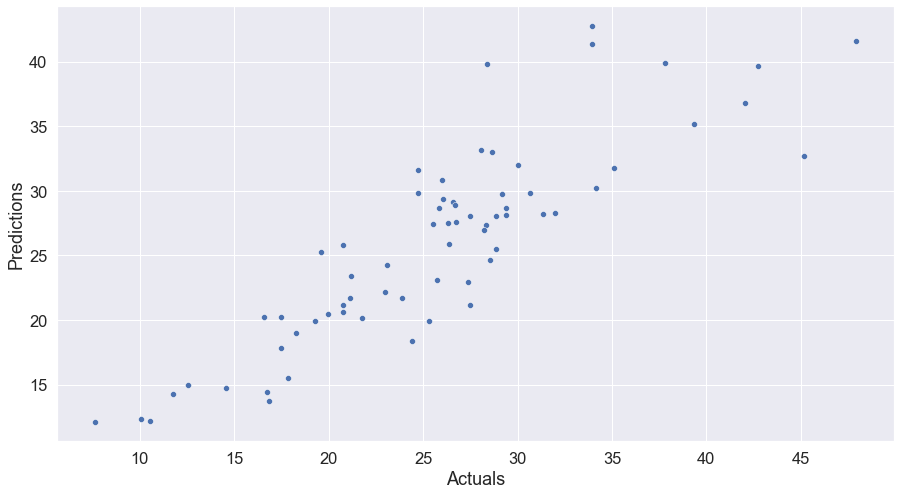

In [44]:
y_pred = pipe.predict(X_test)
evaluate_from_preds(y_test, y_pred)

### Feature Importance

I want to look at the feature importance for the model so that I can get a better sense of what features played a role in prediction

In [45]:
fi = pd.DataFrame({'Feature Importance': pipe['train'].feature_importances_, 'Feature Name': preprocessing_feature_transformers.get_feature_names_out()})

In [46]:
fi.sort_values('Feature Importance',ascending=False, inplace=True)

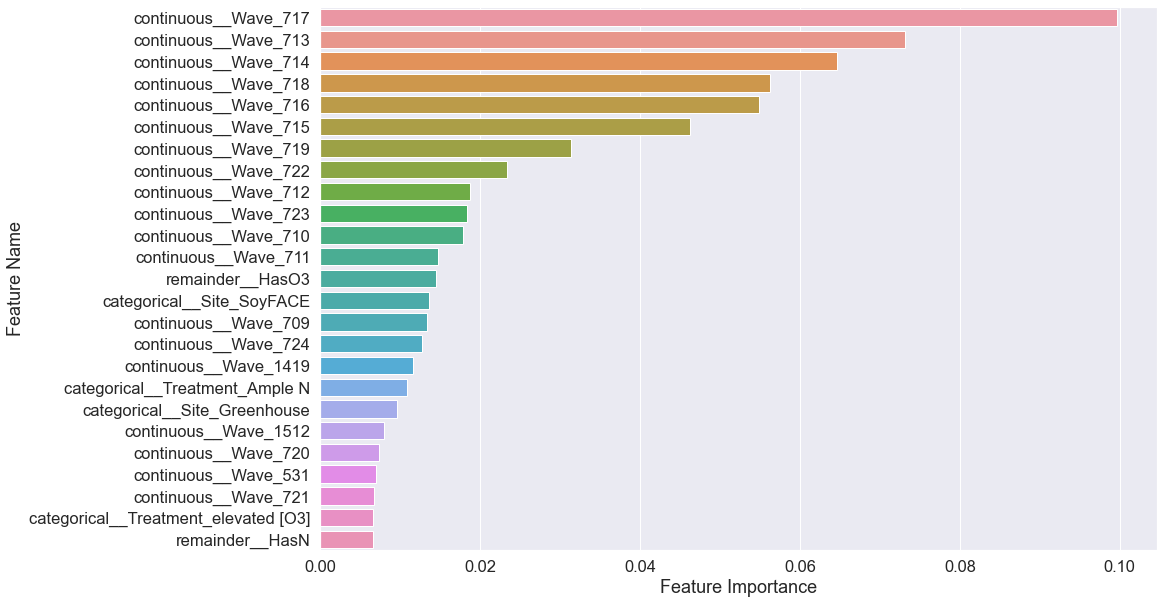

In [47]:
fig = plt.figure(figsize=(15,10))
feat = sns.barplot(x='Feature Importance', y='Feature Name', data=fi.iloc[:25], orient='h')

We can see here that the **wavelengths between 700-725, and more specifically 710-720, are the most import wavelengths for predicting this model**. A future model may look to reduce the number of wavelengths we train on to limit the amount of noise from other wavelengths. It also lookes like the **Site** is determinent of Chlorophyll concentration, as well as the **[03] Treatments** treatment process.

 ### Reducing the Number of wavelengths tested

In [48]:
continuous = [f'Wave_{num}' for num in range(700, 726)]
continuous = pd.Index(continuous)

In [54]:
preprocessing_feature_transformers = ColumnTransformer(
    [
        ('continuous', preprocessing.StandardScaler(), continuous),
        ('categorical', preprocessing.OneHotEncoder(), categorical),
    ],
    remainder='drop'
)

In [55]:
pipe = Pipeline(
    [
        ('preprocessing', preprocessing_feature_transformers),
        ('train', RandomForestRegressor())
    ]
)

In [56]:
pipe.fit(X_train, y_train)

/Users/kevin-ironside/opt/anaconda3/lib/python3.8/site-packages/sklearn/pipeline.py:394: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self._final_estimator.fit(Xt, y, **fit_params_last_step)


Pipeline(steps=[('preprocessing',
                 ColumnTransformer(transformers=[('continuous',
                                                  StandardScaler(),
                                                  Index(['Wave_700', 'Wave_701', 'Wave_702', 'Wave_703', 'Wave_704', 'Wave_705',
       'Wave_706', 'Wave_707', 'Wave_708', 'Wave_709', 'Wave_710', 'Wave_711',
       'Wave_712', 'Wave_713', 'Wave_714', 'Wave_715', 'Wave_716', 'Wave_717',
       'Wave_718', 'Wave_719', 'Wave_720', 'Wave_721', 'Wave_722', 'Wave_723',
       'Wave_724', 'Wave_725'],
      dtype='object')),
                                                 ('categorical',
                                                  OneHotEncoder(),
                                                  Index(['Site', 'Growing Season', 'Genotype_Cleaned', 'Treatment'], dtype='object'))])),
                ('train', RandomForestRegressor())])

R2: 0.7997570246464776
MAE: 2.643310896082095
MSE: 12.971950162322647


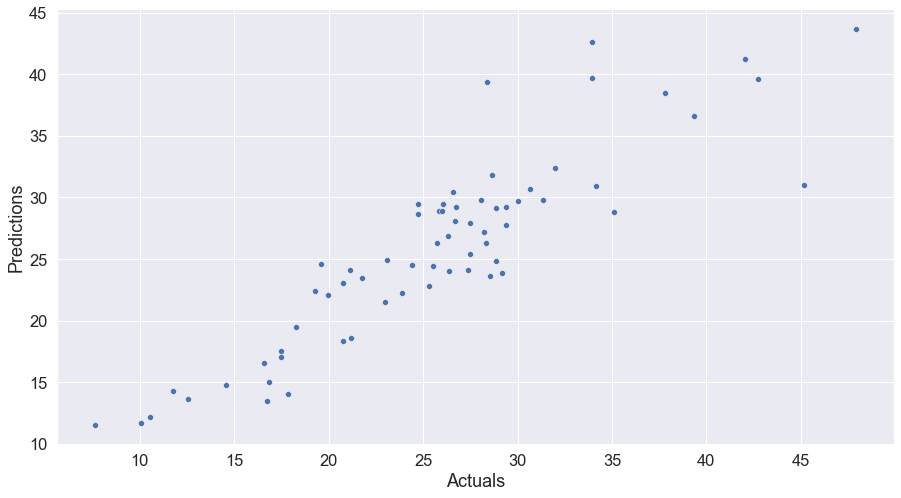

In [57]:
y_pred = pipe.predict(X_test)
evaluate_from_preds(y_test, y_pred)

This increased our models R2 from 0.752 to 0.798! Serializing the model for use later on.

In [27]:
from joblib import dump
dump(pipe, 'src/RandomForestPipeline.joblib')

['src/RandomForestPipeline.joblib']